In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lib import sig_gen
import tensorflow as tf
from tensorflow.keras import layers
from numba import jit

print(tf.VERSION)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


In [6]:
@jit(nopython=True)
def sig_batch_gen(batch, symb, sps):
    """
    generate a signal batch
    no distortion yet
    """
    mibt = np.random.random((batch, 2))+0.3
    sig = np.empty((batch, symb*sps, 2))
    for idx in range(batch):
        msg = np.random.randint(0, 2, symb)
        sig_cpx = sig_gen.gfsk_mod(msg, sps, mibt[idx, 0], mibt[idx, 1])
        sig[idx, :, 0] = sig_cpx.real
        sig[idx, :, 1] = sig_cpx.imag
    return sig, mibt

# sig, mibt = sig_batch_gen(batch, symb, sps)
# print(sig.shape, mibt.shape)
def train_generator(batch, symb, sps):
    while True:
        yield sig_batch_gen(batch, symb, sps)

        
batch = 1024
symb, sps = 64, 4
gen = train_generator(batch, symb, sps)
next(gen)[1].shape

(1024, 2)

In [7]:

%timeit sig_batch_gen(batch, symb, sps)

14.4 ms ± 4.12 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
def build_model(input_shape):
    # build model
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(32, 9, activation='relu',
                            input_shape=input_shape))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(16, 7, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(8, 3, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(2))

    model.compile(optimizer=tf.train.AdamOptimizer(0.001),
                  loss='mse',
                  metrics=['mae'])
#     model.summary()

    return model

model = build_model((symb*sps, 2))

In [9]:
# sanity check
x_test = np.random.rand(5, 256, 2)
model.predict(x_test).shape

(5, 2)

In [10]:
history = model.fit_generator(
    gen,
    steps_per_epoch=100,
    epochs=10
    )
model.save('mibt_est.h5')

Epoch 1/10
100/100 [==============================] - 3s 33ms/step - loss: 0.0807 - mean_absolute_error: 0.2116
Epoch 2/10
100/100 [==============================] - 3s 29ms/step - loss: 0.0332 - mean_absolute_error: 0.1299
Epoch 3/10
100/100 [==============================] - 3s 29ms/step - loss: 0.0223 - mean_absolute_error: 0.1034
Epoch 4/10
100/100 [==============================] - 3s 29ms/step - loss: 0.0195 - mean_absolute_error: 0.0943
Epoch 5/10
100/100 [==============================] - 3s 29ms/step - loss: 0.0188 - mean_absolute_error: 0.0912
Epoch 6/10
100/100 [==============================] - 3s 29ms/step - loss: 0.0179 - mean_absolute_error: 0.0882
Epoch 7/10
100/100 [==============================] - 3s 29ms/step - loss: 0.0179 - mean_absolute_error: 0.0874
Epoch 8/10
100/100 [==============================] - 3s 29ms/step - loss: 0.0172 - mean_absolute_error: 0.0850
Epoch 9/10
100/100 [==============================] - 3s 30ms/step - loss: 0.0170 - mean_absolute_error:

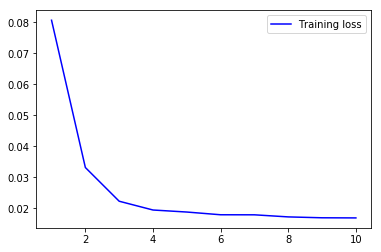

In [11]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.legend()
plt.show()

In [12]:
batch = 1
symb, sps = 64, 4
x_test, target = sig_batch_gen(batch, symb, sps)
print(model.predict(x_test), target)


[[0.6400458 1.1150059]] [[0.5834769  1.08938443]]
